<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/regression/Regression_NO_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [0]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


con quest'aggunta si ha riproducibilità alta ma non perfetta

#Load data

In [0]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
public_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
PA_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
public_targets = df_train.Surv_time_months

In [0]:
PA_targets = df_test.Surv_time_months

In [0]:
public_targets.min()

1

In [0]:
public_targets.max()

72

In [0]:
a=list(public_targets)

In [0]:
a.sort()

In [0]:
print(a)

[1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 12, 12, 12, 12, 12, 13, 13, 13, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 18, 18, 18, 18, 19, 19, 19, 21, 21, 21, 21, 21, 22, 22, 23, 23, 23, 24, 24, 25, 25, 25, 26, 27, 27, 27, 28, 29, 29, 30, 30, 30, 31, 31, 32, 33, 33, 33, 34, 36, 36, 36, 38, 38, 40, 40, 41, 41, 44, 45, 45, 46, 46, 46, 48, 50, 51, 52, 54, 56, 60, 63, 64, 71, 72]


(array([60., 35., 19., 12.,  5.]),
 array([ 1. , 15.2, 29.4, 43.6, 57.8, 72. ]),
 <a list of 5 Patch objects>)

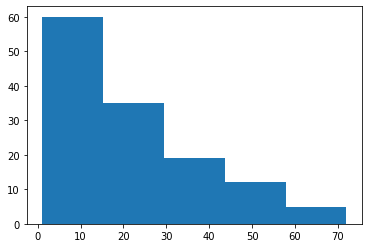

In [0]:
plt.hist(public_targets, 5)

#Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Create the bins.  My target variable has
# max=72 observations, and I want 5 bins.

bins = np.linspace(1, 71, 5)

In [0]:
bins

array([ 1. , 18.5, 36. , 53.5, 71. ])

In [0]:
# Save your Y values in a new ndarray,
# broken down by the bins created above.

y_binned = np.digitize(public_targets, bins)

In [0]:
y_binned

array([1, 1, 2, 3, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1, 2, 2, 2,
       2, 3, 3, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 5])

In [0]:
X_train_big, X_test, y_train_big, y_test = train_test_split(public_data, public_targets, test_size=13, stratify=y_binned, random_state=1)

(array([5., 3., 2., 2., 1.]),
 array([ 1. , 12.8, 24.6, 36.4, 48.2, 60. ]),
 <a list of 5 Patch objects>)

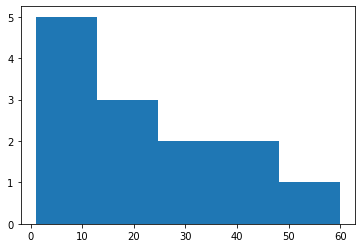

In [0]:
plt.hist(y_test, 5)

#Train Validation Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Create the bins. My target variable has
#  max=72, and I want 5 bins.

bins = np.linspace(1, 71, 5)

In [0]:
bins

array([ 1. , 18.5, 36. , 53.5, 71. ])

In [0]:
# Save your Y values in a new ndarray,
# broken down by the bins created above.

y_binned = np.digitize(y_train_big, bins)

In [0]:
y_binned

array([1, 3, 1, 1, 2, 4, 2, 2, 1, 2, 2, 2, 1, 2, 3, 1, 1, 2, 4, 1, 2, 3,
       1, 2, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 3, 1, 3, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2,
       1, 2, 3, 1, 3, 3, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4,
       5, 1, 1, 1, 1, 3, 1, 2, 2, 2, 2, 3, 3, 1, 1, 3, 3, 5, 1, 3, 2, 1,
       3, 1, 2, 2, 1, 1, 1, 2])

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train_big, y_train_big, test_size=13, stratify=y_binned, random_state=2)                                                                                                               

(array([6., 2., 2., 2., 1.]),
 array([ 4. , 13.4, 22.8, 32.2, 41.6, 51. ]),
 <a list of 5 Patch objects>)

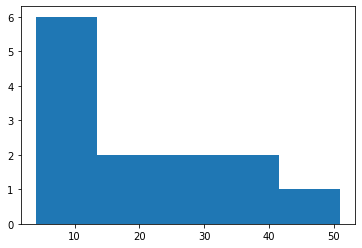

In [0]:
plt.hist(y_val, 5)

#Z score dei dati

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_stand = scaler.fit_transform(X_train)
val_data_stand = scaler.transform(X_val)
test_data_stand = scaler.transform(X_test)

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.9, svd_solver='full')

In [0]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
val_data_stand_pca = pca.transform(val_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [0]:
train_data_stand_pca.shape

(105, 9)

#Z-score dopo PCA

In [0]:
from sklearn.preprocessing import StandardScaler
scaler_2 = StandardScaler()
train_data_stand_pca = scaler_2.fit_transform(train_data_stand_pca)
val_data_stand_pca = scaler_2.transform(val_data_stand_pca)
test_data_stand_pca = scaler_2.transform(test_data_stand_pca)

#Scaling target features

In [0]:
#scalare il survival times tra 0 e 1


#Building Network

In [0]:
from keras import models

In [0]:
from keras import layers

In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import SGD

In [0]:
from keras import regularizers

In [0]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(14, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
                         input_shape=(9,)))
  model.add(layers.Dense(14, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
  #model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))

  model.add(layers.Dense(1))

  rmsp = RMSprop(lr=0.01)
  adagrad = Adagrad(lr=0.01)
  adadelta = Adadelta(lr=1.0, rho=0.95)
  adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
  adamax = Adamax(lr=0.002, beta_1=0.9, beta_2=0.999)
  nadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
#  sgd = SGD(lr=0.01, momentum=0.0, nesterov=False) # NON UTILIZZABILE
#  optimizer='rmsprop'

  model.compile(optimizer=adam, loss='mse', metrics=['mae'])
  return model

Note that you compile the network with the mse loss function—mean squared error,
the square of the difference between the predictions and the targets. This is a widely
used loss function for regression problems.



You’re also monitoring a new metric during training: mean absolute error (MAE). It’s
the absolute value of the difference between the predictions and the targets. For
instance, an MAE of 0.5 on this problem would mean your predictions are off by $500
on average.

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('loss', patience=5, verbose=1, min_lr=0.0001)

In [0]:
num_epochs = 500

model = build_model()
history = model.fit(train_data_stand_pca, train_targets, validation_data=(val_data_stand_pca, val_targets), 
                      epochs= num_epochs, batch_size=1, callbacks=[red_lr])
  
mae_history = history.history['mean_absolute_error']
mae_val_history = history.history['val_mean_absolute_error']
loss_history = history.history['loss']
loss_val_history = history.history['val_loss']

Train on 105 samples, validate on 13 samples
Epoch 1/500
105/105 [==============================] - 1s 7ms/step - loss: 676.4061 - mean_absolute_error: 19.8731 - val_loss: 482.6320 - val_mean_absolute_error: 16.9357
Epoch 2/500
105/105 [==============================] - 0s 1ms/step - loss: 602.4251 - mean_absolute_error: 18.2672 - val_loss: 412.7170 - val_mean_absolute_error: 14.7921
Epoch 3/500
105/105 [==============================] - 0s 1ms/step - loss: 494.6916 - mean_absolute_error: 16.1238 - val_loss: 330.7838 - val_mean_absolute_error: 13.3495
Epoch 4/500
105/105 [==============================] - 0s 1ms/step - loss: 376.0040 - mean_absolute_error: 14.0081 - val_loss: 262.8115 - val_mean_absolute_error: 13.2600
Epoch 5/500
105/105 [==============================] - 0s 1ms/step - loss: 290.4670 - mean_absolute_error: 12.3872 - val_loss: 243.0419 - val_mean_absolute_error: 14.1681
Epoch 6/500
105/105 [==============================] - 0s 1ms/step - loss: 253.6559 - mean_absolute_

In [0]:
len(mae_history)

500

#Plotting training and validation mae

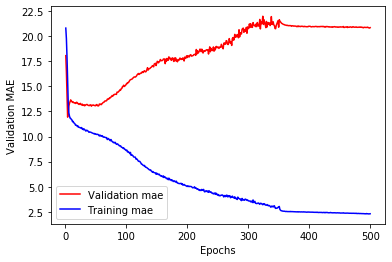

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(mae_val_history) + 1), mae_val_history, 'r', label='Validation mae')
plt.plot(range(1, len(mae_history) + 1), mae_history, 'b', label='Training mae')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()


#Plotting training and validation loss

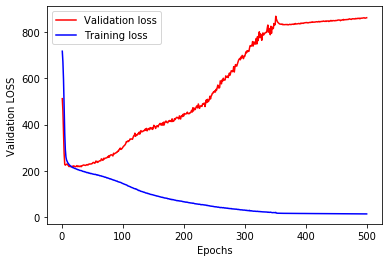

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(loss_val_history) + 1), loss_val_history, 'r', label='Validation loss')
plt.plot(range(1, len(loss_history) + 1), loss_history, 'b', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.legend()
plt.show()

#Test model


In [0]:
model.fit(train_data_stand_pca, train_targets, epochs=80, batch_size=1, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data_stand_pca, y_test)

13/13 [==============================] - 0s 37us/step


In [0]:
test_mae_score

17.643218994140625